# Teste de Hipóteses

Este notebook tem como objetivo validar algumas hipóteses sobre o **churn** de clientes, tentando entender melhor o comportamento das pessoas em certas ocasiões.

Antes de avaliar as hipóteses dos motivos dos clientes abandonarem o serviço, será feito uma etapa de processamento da informação, para lidar com os dados melhores estruturados e ter uma maior facilidade nos testes das hipóteses.

## Bibliotecas e inicializações importantes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats

%matplotlib inline
sns.set()

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

## Funções utilizadas no notebook anterior

In [2]:
def value_counts_percentage(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Método usado para indicar a quantidade de cada valor da coluna
    com sua porcentagem sobre o total dos dados.
    """
    
    # Dataframe com as informações
    display_df = pd.DataFrame(df[column].value_counts())
    display_df = display_df.rename_axis('Valor')
    
    # Quantidade e Porcentagem
    display_df.columns = ['Quantidade']
    display_df['Porcentagem'] = 100 * display_df['Quantidade'] / display_df['Quantidade'].sum()
    
    return display_df

def value_counts_churn(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Método usado para indicar a quantidade de cada valor da coluna
    com sua porcentagem, junto da quantidade de Churn baseado nos
    valores daquele atributo.
    """
    
    # Quantidade e Porcentagem da coluna especifica
    display_df = value_counts_percentage(df, column)
    
    # Quantidad de Churn em cada valor e sua porcentagem
    index_values = display_df.index    
    display_df['Churn'] = [df[(df[column] == i) & (df['Churn'] == 1)].shape[0] 
                           for i in index_values]
    
    display_df['Churn (%)'] = 100 * display_df['Churn'] / display_df['Quantidade']
    return display_df

## Leitura dos dados

In [3]:
DATA_FOLDER = "../data/"
RAW_FOLDER = DATA_FOLDER + 'raw/'

In [4]:
data = pd.read_excel(f"{RAW_FOLDER}Customer-Churn.xlsx")
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0.00,Yes,Yes,72.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,"8,672.45",No
1,8984-HPEMB,Female,0.00,No,No,71.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,"8,477.60",No
2,5989-AXPUC,Female,0.00,Yes,No,68.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,"7,990.05",No
3,5734-EJKXG,Female,0.00,No,No,61.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,"7,365.70",No
4,8199-ZLLSA,Male,0.00,No,No,67.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,"7,804.15",Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,Female,0.00,No,No,53.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.70,"1,005.70",No
7039,9945-PSVIP,Female,0.00,Yes,Yes,25.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,18.70,383.65,No
7040,0827-ITJPH,Male,0.00,No,No,36.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),18.55,689.00,No
7041,9764-REAFF,Female,0.00,Yes,No,59.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),18.40,"1,057.85",No


# Pré-processamento dos dados

Todo o processamento dos dados divididos em etapas bem definidas:

## Retirada de valores nulos

O único atributo que possuí informações faltantes é a coluna **TotalCharges**, pois isso ocorre em clientes que ainda não possuí tempo de serviço. Como são apenas 11 clientes que estão neste conjunto e as informações sobre o tempo não podem ser utilizadas, foi decidido a remoção destas linhas do dataset.

In [5]:
data = data.dropna()
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0.00,Yes,Yes,72.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,"8,672.45",No
1,8984-HPEMB,Female,0.00,No,No,71.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,"8,477.60",No
2,5989-AXPUC,Female,0.00,Yes,No,68.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,"7,990.05",No
3,5734-EJKXG,Female,0.00,No,No,61.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,"7,365.70",No
4,8199-ZLLSA,Male,0.00,No,No,67.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,"7,804.15",Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,Female,0.00,No,No,53.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.70,"1,005.70",No
7039,9945-PSVIP,Female,0.00,Yes,Yes,25.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,18.70,383.65,No
7040,0827-ITJPH,Male,0.00,No,No,36.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),18.55,689.00,No
7041,9764-REAFF,Female,0.00,Yes,No,59.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),18.40,"1,057.85",No


## Retirada do atributo gênero

Como apresentado no notebook de Análise dos dados, o atributo gênero não apresenta nenhuma mudança na **taxa de churn**, além de poder criar regras com possíveis discriminações sobre os clientes. Devido a tais informações, foi decidido a exclusão por completo dessa informação.

In [6]:
data = data.drop(columns=['gender'])
data

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,0.00,Yes,Yes,72.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,"8,672.45",No
1,8984-HPEMB,0.00,No,No,71.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,"8,477.60",No
2,5989-AXPUC,0.00,Yes,No,68.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,"7,990.05",No
3,5734-EJKXG,0.00,No,No,61.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,"7,365.70",No
4,8199-ZLLSA,0.00,No,No,67.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,"7,804.15",Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,0.00,No,No,53.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.70,"1,005.70",No
7039,9945-PSVIP,0.00,Yes,Yes,25.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,18.70,383.65,No
7040,0827-ITJPH,0.00,No,No,36.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),18.55,689.00,No
7041,9764-REAFF,0.00,Yes,No,59.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),18.40,"1,057.85",No


## Divisão da informação sobre Internet e seus tipos

A coluna de **InternetService** possuí a indicação do tipo de internet ou a palavra **No** caso o cliente não possua esse serviço. Várias das informações no dataset incluem a indicação caso o cliente não tenha serviço de internet, o que acaba sendo uma indicação desnecessária, pois esta informação não precisa ser replicada em inúmeras colunas.

In [7]:
data['Internet'] = 1
data.loc[data['InternetService'] == 'No' , 'Internet'] = 0
data = data.astype({'Internet': int})          
data

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Internet
0,7569-NMZYQ,0.00,Yes,Yes,72.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,"8,672.45",No,1
1,8984-HPEMB,0.00,No,No,71.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,"8,477.60",No,1
2,5989-AXPUC,0.00,Yes,No,68.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,"7,990.05",No,1
3,5734-EJKXG,0.00,No,No,61.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,"7,365.70",No,1
4,8199-ZLLSA,0.00,No,No,67.00,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,"7,804.15",Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,0.00,No,No,53.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.70,"1,005.70",No,0
7039,9945-PSVIP,0.00,Yes,Yes,25.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,18.70,383.65,No,0
7040,0827-ITJPH,0.00,No,No,36.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),18.55,689.00,No,0
7041,9764-REAFF,0.00,Yes,No,59.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),18.40,"1,057.85",No,0


## Modificando os dados de Yes/No para uma Flag

Outra informação que facilita as comparações é todas as colunas estarem no mesmo formato, onde será utilizado valores de 0 ou 1 ao inves de No ou Yes.

In [8]:
# Colunas que possuem o 'Yes' como flag indicativa
columns = ['Partner', 'Dependents', 'PhoneService', 
           'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport', 'StreamingTV', 
           'StreamingMovies', 'PaperlessBilling', 'Churn']

# Transforma o 'Yes' em 1 e o resto em 0
for c in columns:
    data.loc[data[c] == 'Yes', c] = 1
    data.loc[data[c] != 1, c] = 0
    data = data.astype({c: int})

data

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Internet
0,7569-NMZYQ,0.00,1,1,72.00,1,1,Fiber optic,1,1,1,1,1,1,Two year,1,Bank transfer (automatic),118.75,"8,672.45",0,1
1,8984-HPEMB,0.00,0,0,71.00,1,1,Fiber optic,1,1,1,1,1,1,Two year,1,Electronic check,118.65,"8,477.60",0,1
2,5989-AXPUC,0.00,1,0,68.00,1,1,Fiber optic,1,1,1,1,1,1,Two year,0,Mailed check,118.60,"7,990.05",0,1
3,5734-EJKXG,0.00,0,0,61.00,1,1,Fiber optic,1,1,1,1,1,1,One year,1,Electronic check,118.60,"7,365.70",0,1
4,8199-ZLLSA,0.00,0,0,67.00,1,1,Fiber optic,1,1,1,1,1,1,One year,1,Bank transfer (automatic),118.35,"7,804.15",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,0.00,0,0,53.00,1,0,No,0,0,0,0,0,0,Two year,0,Mailed check,18.70,"1,005.70",0,0
7039,9945-PSVIP,0.00,1,1,25.00,1,0,No,0,0,0,0,0,0,Two year,1,Mailed check,18.70,383.65,0,0
7040,0827-ITJPH,0.00,0,0,36.00,1,0,No,0,0,0,0,0,0,Two year,1,Credit card (automatic),18.55,689.00,0,0
7041,9764-REAFF,0.00,1,0,59.00,1,0,No,0,0,0,0,0,0,Two year,0,Bank transfer (automatic),18.40,"1,057.85",0,0


## SeniorCitizen e Tenure como dados inteiros:

Estas informações são numéricas e podem ser apresentadas como dados inteiros, ao invés de *float64*.

In [9]:
data = data.astype({"SeniorCitizen": int, "tenure": int})
data

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Internet
0,7569-NMZYQ,0,1,1,72,1,1,Fiber optic,1,1,1,1,1,1,Two year,1,Bank transfer (automatic),118.75,"8,672.45",0,1
1,8984-HPEMB,0,0,0,71,1,1,Fiber optic,1,1,1,1,1,1,Two year,1,Electronic check,118.65,"8,477.60",0,1
2,5989-AXPUC,0,1,0,68,1,1,Fiber optic,1,1,1,1,1,1,Two year,0,Mailed check,118.60,"7,990.05",0,1
3,5734-EJKXG,0,0,0,61,1,1,Fiber optic,1,1,1,1,1,1,One year,1,Electronic check,118.60,"7,365.70",0,1
4,8199-ZLLSA,0,0,0,67,1,1,Fiber optic,1,1,1,1,1,1,One year,1,Bank transfer (automatic),118.35,"7,804.15",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,0,0,0,53,1,0,No,0,0,0,0,0,0,Two year,0,Mailed check,18.70,"1,005.70",0,0
7039,9945-PSVIP,0,1,1,25,1,0,No,0,0,0,0,0,0,Two year,1,Mailed check,18.70,383.65,0,0
7040,0827-ITJPH,0,0,0,36,1,0,No,0,0,0,0,0,0,Two year,1,Credit card (automatic),18.55,689.00,0,0
7041,9764-REAFF,0,1,0,59,1,0,No,0,0,0,0,0,0,Two year,0,Bank transfer (automatic),18.40,"1,057.85",0,0


## Variáveis categóricas

As colunas de **InternetService**, **Contract** e **PaymentMethod** possuem valores categóricos e necessitam de uma modificação para serem melhores utilizados. Para isso, cada um dos seus valores serão adicionados em colunas separadas, com flags indicando quais categorias são utilizadas:

In [10]:
columns = ['InternetService', 'Contract', 'PaymentMethod']

data = pd.get_dummies(data, columns=columns)
data = data.drop(columns=['InternetService_No'])
data

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Internet,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7569-NMZYQ,0,1,1,72,1,1,1,1,1,1,1,1,1,118.75,"8,672.45",0,1,0,1,0,0,1,1,0,0,0
1,8984-HPEMB,0,0,0,71,1,1,1,1,1,1,1,1,1,118.65,"8,477.60",0,1,0,1,0,0,1,0,0,1,0
2,5989-AXPUC,0,1,0,68,1,1,1,1,1,1,1,1,0,118.60,"7,990.05",0,1,0,1,0,0,1,0,0,0,1
3,5734-EJKXG,0,0,0,61,1,1,1,1,1,1,1,1,1,118.60,"7,365.70",0,1,0,1,0,1,0,0,0,1,0
4,8199-ZLLSA,0,0,0,67,1,1,1,1,1,1,1,1,1,118.35,"7,804.15",1,1,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,0,0,0,53,1,0,0,0,0,0,0,0,0,18.70,"1,005.70",0,0,0,0,0,0,1,0,0,0,1
7039,9945-PSVIP,0,1,1,25,1,0,0,0,0,0,0,0,1,18.70,383.65,0,0,0,0,0,0,1,0,0,0,1
7040,0827-ITJPH,0,0,0,36,1,0,0,0,0,0,0,0,1,18.55,689.00,0,0,0,0,0,0,1,0,1,0,0
7041,9764-REAFF,0,1,0,59,1,0,0,0,0,0,0,0,0,18.40,"1,057.85",0,0,0,0,0,0,1,1,0,0,0


### Agrupando pagamentos automáticos

Dois tipos de pagamentos encontrados na coluna **PaymentMethod** são considerados de forma automática: 

- Bank transfer (automatic)
- Credit card (automatic)

E em ambos os casos, a **taxa de churn** verificada na utilização desses métodos é praticamente a mesma. Devido a esse comportamento, ambas colunas serão únidas em apenas uma, que tem como foco considerar pagamentos automáticos.

In [11]:
columns = ['PaymentMethod_Bank transfer (automatic)', 
           'PaymentMethod_Credit card (automatic)']

data['PaymentMethod_automatic'] = data[columns].sum(axis=1)
data.loc[data['PaymentMethod_automatic'] > 1, 'PaymentMethod_automatic'] = 1
data = data.drop(columns=columns)
data

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Internet,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_automatic
0,7569-NMZYQ,0,1,1,72,1,1,1,1,1,1,1,1,1,118.75,"8,672.45",0,1,0,1,0,0,1,0,0,1
1,8984-HPEMB,0,0,0,71,1,1,1,1,1,1,1,1,1,118.65,"8,477.60",0,1,0,1,0,0,1,1,0,0
2,5989-AXPUC,0,1,0,68,1,1,1,1,1,1,1,1,0,118.60,"7,990.05",0,1,0,1,0,0,1,0,1,0
3,5734-EJKXG,0,0,0,61,1,1,1,1,1,1,1,1,1,118.60,"7,365.70",0,1,0,1,0,1,0,1,0,0
4,8199-ZLLSA,0,0,0,67,1,1,1,1,1,1,1,1,1,118.35,"7,804.15",1,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,0,0,0,53,1,0,0,0,0,0,0,0,0,18.70,"1,005.70",0,0,0,0,0,0,1,0,1,0
7039,9945-PSVIP,0,1,1,25,1,0,0,0,0,0,0,0,1,18.70,383.65,0,0,0,0,0,0,1,0,1,0
7040,0827-ITJPH,0,0,0,36,1,0,0,0,0,0,0,0,1,18.55,689.00,0,0,0,0,0,0,1,0,0,1
7041,9764-REAFF,0,1,0,59,1,0,0,0,0,0,0,0,0,18.40,"1,057.85",0,0,0,0,0,0,1,0,0,1


# Teste de Modelo (Machine Learning)

Antes de avaliar as hipóteses manualmente, será avaliado os resultados utilizando um modelo de *machine learning* para encontrar possíveis *insights* que podêm ter passado despercebidos na étapa de análise dos dados.

## Normalização dos dados numéricos

Por se tratar de um conjunto de informações relativamente pequeno, será optado por avaliar os resultados em um modelo "mais simples", para evitar problemas de **overfitting** na predição dos dados.

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Normalização dos dados numéricos
scaler = MinMaxScaler()

df = data.copy()
df['tenure'] = scaler.fit_transform(df[['tenure']])
df['MonthlyCharges'] = scaler.fit_transform(df[['MonthlyCharges']])
df['TotalCharges'] = scaler.fit_transform(df[['TotalCharges']])
df

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Internet,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_automatic
0,7569-NMZYQ,0,1,1,1.00,1,1,1,1,1,1,1,1,1,1.00,1.00,0,1,0,1,0,0,1,0,0,1
1,8984-HPEMB,0,0,0,0.99,1,1,1,1,1,1,1,1,1,1.00,0.98,0,1,0,1,0,0,1,1,0,0
2,5989-AXPUC,0,1,0,0.94,1,1,1,1,1,1,1,1,0,1.00,0.92,0,1,0,1,0,0,1,0,1,0
3,5734-EJKXG,0,0,0,0.85,1,1,1,1,1,1,1,1,1,1.00,0.85,0,1,0,1,0,1,0,1,0,0
4,8199-ZLLSA,0,0,0,0.93,1,1,1,1,1,1,1,1,1,1.00,0.90,1,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0621-CXBKL,0,0,0,0.73,1,0,0,0,0,0,0,0,0,0.00,0.11,0,0,0,0,0,0,1,0,1,0
7039,9945-PSVIP,0,1,1,0.34,1,0,0,0,0,0,0,0,1,0.00,0.04,0,0,0,0,0,0,1,0,1,0
7040,0827-ITJPH,0,0,0,0.49,1,0,0,0,0,0,0,0,1,0.00,0.08,0,0,0,0,0,0,1,0,0,1
7041,9764-REAFF,0,1,0,0.82,1,0,0,0,0,0,0,0,0,0.00,0.12,0,0,0,0,0,0,1,0,0,1


## Retirada do ID do cliente

In [13]:
df = df.drop(columns=['customerID'])
df

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Internet,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_automatic
0,0,1,1,1.00,1,1,1,1,1,1,1,1,1,1.00,1.00,0,1,0,1,0,0,1,0,0,1
1,0,0,0,0.99,1,1,1,1,1,1,1,1,1,1.00,0.98,0,1,0,1,0,0,1,1,0,0
2,0,1,0,0.94,1,1,1,1,1,1,1,1,0,1.00,0.92,0,1,0,1,0,0,1,0,1,0
3,0,0,0,0.85,1,1,1,1,1,1,1,1,1,1.00,0.85,0,1,0,1,0,1,0,1,0,0
4,0,0,0,0.93,1,1,1,1,1,1,1,1,1,1.00,0.90,1,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0.73,1,0,0,0,0,0,0,0,0,0.00,0.11,0,0,0,0,0,0,1,0,1,0
7039,0,1,1,0.34,1,0,0,0,0,0,0,0,1,0.00,0.04,0,0,0,0,0,0,1,0,1,0
7040,0,0,0,0.49,1,0,0,0,0,0,0,0,1,0.00,0.08,0,0,0,0,0,0,1,0,0,1
7041,0,1,0,0.82,1,0,0,0,0,0,0,0,0,0.00,0.12,0,0,0,0,0,0,1,0,0,1


## Divisão dos dados de Treino/Teste

In [14]:
from sklearn.model_selection import train_test_split

# Divisão de dados de treino e teste
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

## Treinamento do modelo Random Forest

Como estamos utilizando um processo apenas para visualizar hipóteses dos motivos dos clientes sairem, será utilizado um modelo bem generalista que costuma dar bons resultados iniciais.

### Validação Cruzada

A validação cruzada tem como objetivo avaliar o desempenho do modelo em diversos treinos e testes diferentes, para tentar se encontrar um resultado médio. Esta prática é uma boa utilização para encontrar os melhores hiperparâmetros e para se ter um resultado mais generalista ao problema.

Para validar este dado, será utilizado o F1-Score do modelo, que utiliza como base a precisão e o recall das predições, dando assim uma métrica que indica melhor se o entendimento do modelo referente ao problema.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve

# Modelo utilizado e a média do valor de ROC_AUC em 7 cvs
model = RandomForestClassifier(max_depth=3, class_weight='balanced', random_state=42)
results = cross_val_score(model, X_train, y_train, cv=7, scoring='f1').mean()
print("Média de F1-Score:", round(results, 2))

Média de F1-Score: 0.62


62% de F1-Score não é um dos melhores resultados a se encontrar, podendo indicar que o modelo pode estar tendo certa dificuldade em predizer alguma das classes. Para se ter um melhor entendimento do problema, será avaliado a **matriz de confusão** da predição no conjunto de testem, junto do **relatório de classificação**.

### Matriz de confusão

A matriz de confusão permite visualizar as predições do modelo, com indicações dos seus tipos de erros.

In [16]:
def make_confusion_matrix(cf: np.ndarray,
                          normalized_cf: np.ndarray,
                          group_names: list = None,
                          categories: list = 'auto',
                          count: bool = True,
                          percent: bool = True,
                          cbar: bool = True,
                          xyticks: bool = True,
                          xyplotlabels: bool = True,
                          sum_stats: bool = True,
                          figsize: tuple = None,
                          cmap: str = 'Blues',
                          title: str = None):
    '''
    Esta função fará um plot "bonito" de uma matriz de confusão do sklearn 
    usando a visualização heatmap do Seaborn.
    
    Argumentos
    ---------
    cf:             Matriz de confusão a ser "plotada".
    group_names:    List de strings que representam as labels linha por linha a
                    serem mostradas em cada "quadrado". Por padrão, a opção é
                    None.
    categories:     Lista de strings que contém as categorias a serem mostradas
                    no eixo x e y. Por padrão, a opção é 'auto'.
    count:          Se for True, mostra a quantidade exata na matriz de 
                    confusão. Por padrão, a opção é True.
    percent:        Se for True, mostra a proporção em cada categoria. Por 
                    padrão, a opção é True.
    cbar:           Se for True, mostra a barra de cores. As cores da barra
                    são baseadas nos valores da matriz de confusão. Por padrão,
                    a opção é True.
    xyticks:        Se for True, mostra os 'ticks' em x e y. Por padrão, a opção
                    é True.
    xyplotlabels:   Se for True, mostra 'Valor Real' e 'Valor Predito' na
                    figura. Por padrão, a opção é True.
    sum_stats:      Se for True, apresenta o sumário estatístico embaixo da
                    figura. Por padrão, a opção é True.
    figsize:        Tupla representando o tamanho da figura. Por padrão, a opção
                    terá os valores padrões do matplotlib.
    cmap:           Colormap dos valores apresentados na imagem. Por padrão, a
                    opção é 'Blues'.
    title:          Título em do Heatmap. Por padrão, a opção é None.               
    '''


    # Código para adicionar o texto em cada um dos quadrados.
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) 
            for value in normalized_cf.flatten()
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip() 
        for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Código para gerar o sumário estatístico, junto de seu texto.
    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # Se a matriz de confusão for de tamanho 2, dá pra adicionar
        # mais informações além da acurácia.
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.3f}\nPrecisão={:0.3f}\n"
            stats_text += "Recall={:0.3f}\nF1 Score={:0.3f}"
            stats_text = stats_text.format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAcurácia={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # seta os parâmetros da figura por padrão, caso seja nulo.
    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    # Não imprime as categorias, caso o xyticks seja falso.
    if xyticks==False:
        categories=False

    # Cria a visualização Heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(normalized_cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar,
                xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Valor Real')
        plt.xlabel('Valor Predito' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    plt.show()

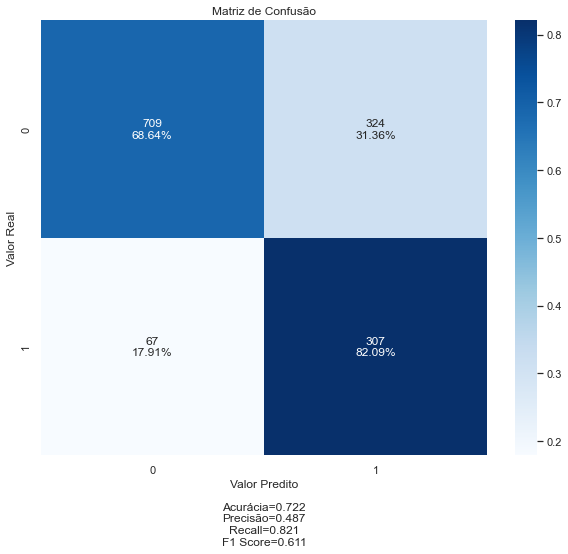

In [17]:
from sklearn.metrics import confusion_matrix

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cf = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf, confusion_matrix(y_test, y_pred, normalize='true'), 
                      title='Matriz de Confusão', figsize=(10,8))

Aqui é possível visualizar com mais clareza os resultados do modelo. Este modelo apresenta uma maior facilidade de indicar um cliente que **não está no valor de Churn**, tendo poucos predições como **falsos-negativos**. Entretanto, ao indicar que o cliente está em **Churn**, o mesmo encontra um resultado de 48.7% de precisão, o que significa que mais da metade das predições são feitas de forma errada, indicando **Churn** em clientes que não são.

### Relatório de Classificação

Apesar de termos alguns resultados sobre precisão e recall ao visualizar a matriz de confusão, é interessante validar esses resultados de forma completa, vendo essas métricas para ambas as classes do problema.

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1033
           1       0.49      0.82      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.72      0.74      1407



Tendo a visualização completa desses resultados, podemos ver que a precisão de um cliente **Não-Churn** é bastante alta, chegando a 91%. Isso significa que o modelo possuí uma alta confiabilidade ao indicar esta informação. Apesar dos resultados encontrados, este modelo poderia ser utilizado como um filtro para uma análise detalhada, onde clientes **Não-Churn** poderia ser consideradas confiáveis mas não podendo seguir essa afirmação ao serem testados como positivos.

## Importância de atributos do modelo

Apesar dos resultados encontrados pelos modelos, o objetivo principal aqui é criar hipóteses dos motivos de abandono dos clientes e tentar reverter essa situação. Com o treinamento do modelo, podemos verificar o que o mesmo considera variáveis de maior destaque para se chegar ao resultado:

In [19]:
def attributes_importance(model, attributes):
    
    # importância dos atributos
    importances = model.feature_importances_
    
    # Cria um DataFrame com as features e sua importância
    att_importances = pd.DataFrame(data=importances, columns=['Importância'], index=attributes)
    return att_importances.sort_values('Importância', ascending=False)

attributes_importance(model, X.columns)

,Importância
Contract_Month-to-month,0.26
Contract_Two year,0.15
tenure,0.13
InternetService_Fiber optic,0.09
PaymentMethod_Electronic check,0.08
TotalCharges,0.06
Internet,0.06
MonthlyCharges,0.05
Contract_One year,0.03
PaymentMethod_automatic,0.02


É possível verificar que o atributo de maior destaque para o modelo é o tipo de contrato **Month-to-month**. Isso não é nenhuma surpresa, pois esta informação foi verificada na etapa da Análise dos dados. Outro ponto interessante é o contrato **Two year** estar como segundo em termos de importância, pois foi verificado que esse tipo de contrato é um dos atributos que menos possuí **Churn**, o que indica que o mesmo é utilizado para se chegar as predições negativas do modelo.

Além disso, é possível verificar que o tempo de uso, o tipo de internet, os gastos do cliente e seu método de pagamento são bastante utilizados pelo modelo em comparação as demais features. Estas informações acrescentam bastante as descobertas feitas na etapa de análise, pois indica que essas informações possuem bastante relação a **taxa de churn** do serviço.

# Avaliação de Hipóteses

Aqui será válidado algumas hipóteses sobre as informações, utilizando descobertas feitas pela análise dos dados e os resultados de features importantes para o modelo.

## Como diminuir o Churn de clientes idosos?

Na etapa de análise de dados, foi observado que clientes idosos representam cerca de 16% dos clientes atendidos, mas possuem uma **taxa de churn** de 41%. É um grande aumento em comparação ao grupo de **não-idosos**, o que faz necessário entender melhor esses motivos.

Para uma visualização inicial, será verificado a diferença de custo mensal entre clientes idosos e não-idosos.

In [20]:
data.groupby('SeniorCitizen')['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,,,,,,,,
0,"5,890.00",61.89,30.32,18.25,25.60,65.88,86.79,118.75
1,"1,142.00",79.82,23.76,18.95,70.15,84.85,98.07,117.45


É possível verificar que clientes considerados idosos costumam pagar mais pelo serviço do que os não-idosos, sendo verificado que 75% dos idosos paga pelo menos 70.15. Esta informação indica maior destaque ao verificar que ao analisar esta mesma parcela, os não-idosos pagam pelo menos 25.60, indicando um aumento de quase 45.

Para uma visualização mais afundo, podemos verificar o comportamento do custo mensal verificando se o cliente é **idoso** e se está como **churn** no conjunto de dados.

In [21]:
data.groupby(['SeniorCitizen', 'Churn'])['MonthlyCharges'].describe()

count  mean   std   min   25%   50%   75%    max
SeniorCitizen Churn                                                    
0             0     4,497.00 58.66 30.97 18.25 24.40 59.80 84.90 118.75
              1     1,393.00 72.30 25.45 18.85 53.85 78.10 91.85 118.35
1             0       666.00 79.18 25.55 18.95 65.21 84.85 99.17 117.35
              1       476.00 80.71 21.01 19.45 73.62 84.82 95.71 117.45

Aqui podemos verificar que um idoso costuma ter um custo mais elevado independente de ser **Churn** ou não. Então, isso indica que um idoso está disposto a ter um **serviço de custo elevado**, tendo apenas quais mudanças não estão sendo atendidas.

Como as colunas foram adicionadas como 0/1, podemos verificar a média de cada uma delas em clientes idosos (pois assim temos a porcentagem de clientes que utilizam tal serviço), verificando suas diferenças entre **Churn** ou não.

In [22]:
data[data['SeniorCitizen'] == 1].groupby('Churn').mean()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Internet,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_automatic
Churn,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.56,0.10,42.06,0.91,0.58,0.33,0.49,0.47,0.31,0.52,0.53,0.72,79.18,"3,494.21",0.93,0.27,0.66,0.55,0.24,0.21,0.42,0.08,0.51
1,1.00,0.42,0.05,21.03,0.91,0.59,0.13,0.31,0.32,0.11,0.48,0.51,0.84,80.71,"1,853.79",0.99,0.16,0.83,0.93,0.06,0.01,0.67,0.09,0.24


Apesar de uma visualização bastante extensa horizontalmente, é possível filtrar e avaliar features que tenham uma maior discrepância entre os grupos

In [23]:
columns = ['OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport', 'InternetService_Fiber optic',
           'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
           'PaymentMethod_Electronic check', 'PaymentMethod_automatic']

data[data['SeniorCitizen'] == 1].groupby('Churn')[columns].mean()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_automatic
Churn,,,,,,,,,,
0,0.33,0.49,0.47,0.31,0.66,0.55,0.24,0.21,0.42,0.51
1,0.13,0.31,0.32,0.11,0.83,0.93,0.06,0.01,0.67,0.24


É possível relacionar algumas informações sobre os clientes:

- 93% dos idosos que desistem utilizam um sistema de contrato mês-a-mês
- 83% dos idosos utilizam internet de fibra óptica
- Idosos que desistem do serviço possuem menos adições de internet
- 67% dos idoso que desistem do serviço utilizam pagamento como cheque eletrônico.

### **Hipótese de solução**

Como foi validado nos dados completos, boa parte dos clientes em geral que desistem do serviço utilizam um tipo de contrato mês-a-mês, onde indica um destaque do grupo de clientes que precisam de uma maior atenção. Já no aspecto de clientes idosos, é verificado que os que acabam desistindo do produto têm menos serviços extras de internet, em especial o de **suporte técnico**. Utilizando um conhecimento geral que a internet é algo mais "recente" e clientes idosos possam ter uma maior dificuldade para utilizar certos serviços, fica ciente que a adição de um suporte técnico resultaria em uma **menor taxa de churn** para este grupo especifíco.

In [24]:
hip_df1 = data[(data['SeniorCitizen'] == 1) & (data['Contract_Month-to-month'] == 1)].copy()

value_counts_churn(hip_df1, 'TechSupport')

,Quantidade,Porcentagem,Churn,Churn (%)
Valor,,,,
0,710,87.98,408,57.46
1,97,12.02,33,34.02


Avaliando a informação apenas com o **Suport Técnico**, é possível verificar que a adição desse serviço em clientes **idosos** e com contratos **mensais**, causa uma queda da **Taxa de Churn** de 57.46% para 34.02%

Além disso, podemos melhorar essa visualização verificando se as adições de mais serviços de internet acaba diminuindo a taxa de churn resultante.

In [25]:
columns = ['OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport']

hip_df1['CountServices'] = hip_df1[columns].sum(axis=1)
value_counts_churn(hip_df1, 'CountServices')

,Quantidade,Porcentagem,Churn,Churn (%)
Valor,,,,
0,315,39.03,201,63.81
1,286,35.44,160,55.94
2,154,19.08,68,44.16
3,47,5.82,11,23.40
4,5,0.62,1,20.00


Aqui é possível verificar ainda mais este comportamento, onde um cliente que não possuí nenhum tipo de adição do serviço de internet acaba tendo uma **taxa de churn** de 63.81% e a inclusão de pelo menos 3 serviços já diminuem essa taxa para 23.4% de churn.

In [26]:
hip_df1.groupby('CountServices')['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
CountServices,,,,,,,,
0,315.00,71.81,20.45,19.20,69.65,74.95,85.35,96.70
1,286.00,80.45,19.54,28.45,74.40,85.08,95.86,103.95
2,154.00,85.30,21.30,33.45,70.12,94.17,103.50,108.80
3,47.00,92.41,18.38,50.00,84.32,95.30,108.93,113.20
4,5.00,109.35,9.65,94.20,105.70,112.90,116.50,117.45


Como foi verificado que clientes idosos já costumam pagar mais pelos serviços, a média de gastos para adição de pelo menos 3 serviços aumentaria os custos mensais em 10 para idosos que já têm tendência a desisterem do processo. 

Sendo assim, acredito que uma solução que levaria a diminuição da **taxa de churn em idosos** seria focar em clientes que utilizam contratos mensais, verificando quais não possuem a adição de serviços extras de internet, podendo apresentar com mais calma as vantagens e benefícios que a adição destes serviços causariam ao cliente, tentando modificar seus contratos para planos mais duradouros (Um ou dois anos).

## Clientes com mais serviços de internet têm menores chances de desistirem do plano?

Ao visualizar os clientes idosos, foi verificado que a adição de serviços extras de internet diminuem a **taxa de churn** desses clientes. Este comportamento segue para todos os clientes da base?

In [27]:
columns = ['OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport']

hip_df2 = data.copy()
hip_df2['CountServices'] = hip_df2[columns].sum(axis=1)
value_counts_churn(hip_df2, 'CountServices')

,Quantidade,Porcentagem,Churn,Churn (%)
Valor,,,,
0,2787,39.63,831,29.82
1,1467,20.86,570,38.85
2,1372,19.51,326,23.76
3,937,13.32,117,12.49
4,469,6.67,25,5.33


É possível verificar que o comportamento segue ao analisar todos os clientes, tendo um destaque maior ainda que **adicionar serviços de internet** resultam em **taxas de churn menores**. Entretanto, é possível avaliar que a adição de apenas um serviço aumenta a taxa de churn em comparação a clientes que possuem nenhum. Uma das possibilidades, é que existem dois grupos de clientes que não possuem nenhum serviço extra: **os que possuem internet e os que NÃO possuem**.

Para validar esta informação de forma mais correta, iremos verificar a comparação de serviços de internet utilizando apenas clientes que possuam internet.

In [28]:
results = value_counts_churn(hip_df2[hip_df2['Internet'] == 1], 'CountServices')
results.sort_index()

,Quantidade,Porcentagem,Churn,Churn (%)
Valor,,,,
0,1267,22.99,718,56.67
1,1467,26.61,570,38.85
2,1372,24.89,326,23.76
3,937,17.00,117,12.49
4,469,8.51,25,5.33


Agora é possível validar ainda mais tal comportamento, ficando interessante a adição que clientes existem mais clientes com 1 ou 2 serviços, dos que não recebem nenhum serviço extra.

### **Hipótese de solução**

A grande maioria dos clientes que possuem internet e não recebem nenhum serviço extra acabam desistindo do produto. Uma das maneiras de tentar diminuir o **churn** avaliando todos os clientes é através da adição de serviços de internet, ao inves de entregar um serviço sem essas adições.

Como visto anteriormente, um cliente que recebe 2 serviços extras possuí uma **taxa de churn** de 23.76%, onde um cliente com internet sem nenhuma adição extra está com 56.67%, indicando que mais da metade desses clientes desistem do serviço.

In [29]:
value_counts_churn(hip_df2[hip_df2['CountServices'] == 0], 'Internet')

,Quantidade,Porcentagem,Churn,Churn (%)
Valor,,,,
0,1520,54.54,113,7.43
1,1267,45.46,718,56.67


Além disso, ao comparar clientes **sem internet** com os que **possuam internet sem serviço extra**, podemos verificar que existe uma diferença de mais de 50%, o que indica que entregar esse serviço de forma mais simples acaba resultando numa perda grande de clientes.

In [30]:
hip_df2[hip_df2['Internet'] == 1].groupby(['CountServices'])['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
CountServices,,,,,,,,
0,"1,267.00",67.77,19.60,23.45,50.00,71.05,82.28,97.65
1,"1,467.00",73.78,21.22,28.45,53.70,78.90,91.00,104.05
2,"1,372.00",79.58,21.68,33.15,59.80,83.20,99.58,108.80
3,937.00,82.89,21.26,37.70,65.05,84.10,104.65,114.10
4,469.00,90.99,19.60,43.25,78.45,90.10,112.10,118.75


Ao comparar os dados de gastos mensais dos clientes com internet e diferentes quantidades de serviços extras, é possível verificar que a adição de 3 serviços causam um aumento de 15 (doláres?). Como solução, seria importante verificar com os clientes que utilizam internet sem serviços extras sobre os ganhos dessas adições, podendo adicionar períodos de testes para mostrar na prática que esses serviços resultam em um sistema mais eficiente para o cliente.

## Avaliando mudanças de pagamento

Um ponto que trouxe certo destaque na análise dos dados foi o de diferentes tipos de pagamentos, e como o de **Eletronic Check** acaba tendo uma maior **taxa de churn** que os outros. Nesta hipótese, será avaliado as diferenças entre esses tipos e propor tentativas para diminuir esta taxa.

In [31]:
columns = ['PaymentMethod_Electronic check', 
           'PaymentMethod_Mailed check', 
           'PaymentMethod_automatic']

data.groupby('Churn')[columns].mean()

,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_automatic
Churn,,,
0,0.25,0.25,0.50
1,0.57,0.16,0.26


Verificando os grupos dos diferentes tipos de pagamentos, é possível verificar que os clientes que utilizam o método de pagamento de **Eletronic Check** possuem uma **Taxa de Churn** de 57%. Além disso, é possível verificar que metade dos clientes que seguem com o serviço utilizam uma forma de pagamento automática.

In [32]:
columns = ['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year']

data.groupby(['PaymentMethod_automatic'])[columns].mean()

,Contract_Month-to-month,Contract_One year,Contract_Two year
PaymentMethod_automatic,,,
0,0.69,0.17,0.14
1,0.37,0.26,0.37


Já aqui podemos verificar que os clientes que utilizam pagamento automático estão com os tipos de contratos mais bem distribuídos, enquanto que os que não utilizam esse tipo de serviço estão em sua maioria em contratos mensais.

In [33]:
columns = ['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year']

data.groupby(['PaymentMethod_Electronic check'])[columns].mean()

,Contract_Month-to-month,Contract_One year,Contract_Two year
PaymentMethod_Electronic check,,,
0,0.43,0.24,0.33
1,0.78,0.15,0.07


Analisando apenas o pagamento por cheque eletrônico, é possível verificar que a maioria dos contratos se encontra em pagamentos mensais. Com esta informação em mente, é interessante verificar com mais atenção o grupo de pagamento por **Eletronic Check** + **Contrato mensal**.

In [34]:
hip_df3 = data[(data['PaymentMethod_Electronic check'] == 1) & (data['Contract_Month-to-month'] == 1)].copy()
hip_df3.groupby('Churn').mean()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Internet,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_automatic
Churn,,,,,,,,,,,,,,,,,,,,,,,,
0,0.24,0.40,0.21,22.41,0.90,0.42,0.21,0.35,0.27,0.20,0.40,0.40,0.69,71.75,"1,768.71",0.93,0.33,0.61,1.00,0.00,0.00,1.00,0.00,0.00
1,0.31,0.33,0.13,14.14,0.91,0.48,0.11,0.25,0.26,0.10,0.46,0.45,0.81,77.78,"1,215.23",0.99,0.19,0.79,1.00,0.00,0.00,1.00,0.00,0.00


Verificando esses dados, através da taxa de churn para cada uma das features no grupo em questão, é verificado poucas mudanças em comparação as hipóteses anteriores, podendo ficar em questão que este método de pagamento **possa** ser o maior dos problemas, e não os serviços prestados aos clientes desse grupo.

In [35]:
contract_columns = ['Contract_Month-to-month', 
                    'Contract_One year', 
                    'Contract_Two year']

payment_columns = ['PaymentMethod_Electronic check', 
                   'PaymentMethod_Mailed check', 
                   'PaymentMethod_automatic']


def return_classes(df, columns, column_name):
    """
    Função simples que transforma várias colunas de flag
    em uma coluna com a classe em questão.
    """
    for c in columns:
        df.loc[df[c] == 1, column_name] = c
    
    df = df.drop(columns=columns)
    return df

# Retorna as colunas de forma de classes
hip_df3 = data.copy()
hip_df3 = return_classes(hip_df3, contract_columns, 'ContractType')
hip_df3 = return_classes(hip_df3, payment_columns, 'PaymentType')

In [36]:
columns = ['ContractType', 'PaymentType']

hip_df3.groupby(columns)['MonthlyCharges'].describe()

count  mean   std  \
ContractType            PaymentType                                           
Contract_Month-to-month PaymentMethod_Electronic check 1,850.00 74.99 22.71   
                        PaymentMethod_Mailed check       893.00 46.05 25.12   
                        PaymentMethod_automatic        1,132.00 68.41 26.29   
Contract_One year       PaymentMethod_Electronic check   347.00 79.10 27.30   
                        PaymentMethod_Mailed check       336.00 44.38 27.65   
                        PaymentMethod_automatic          789.00 67.73 31.03   
Contract_Two year       PaymentMethod_Electronic check   168.00 84.34 28.93   
                        PaymentMethod_Mailed check       375.00 38.60 27.21   
                        PaymentMethod_automatic        1,142.00 64.73 33.97   

                                                         min   25%   50%  \
ContractType            PaymentType                                        
Contract_Month-to-month PaymentMethod_Electronic check 18.85 60.07 79.72   
                        PaymentMethod_Mailed check     18.80 20.35 45.30   
                        PaymentMethod_automatic        18.75 49.89 74.40   
Contract_One year       PaymentMethod_Electronic check 19.05 59.92 89.20   
                        PaymentMethod_Mailed check     18.80 20.05 33.58   
                        PaymentMethod_automatic        18.25 41.15 71.40   
Contract_Two year       PaymentMethod_Electronic check 19.20 65.67 94.45   
                        PaymentMethod_Mailed check     18.70 19.95 24.20   
                        PaymentMethod_automatic        18.40 25.00 70.47   

                                                          75%    max  
ContractType            PaymentType                                   
Contract_Month-to-month PaymentMethod_Electronic check  91.84 117.45  
                        PaymentMethod_Mailed check      67.45 112.95  
                        PaymentMethod_automatic         89.66 114.50  
Contract_One year       PaymentMethod_Electronic check 100.85 118.60  
                        PaymentMethod_Mailed check      64.93 115.10  
                        PaymentMethod_automatic         95.65 118.35  
Contract_Two year       PaymentMethod_Electronic check 107.97 118.65  
                        PaymentMethod_Mailed check      57.72 118.60  
                        PaymentMethod_automatic         92.28 118.75

Além disso, é possível verificar que esse tipo de pagamento sempre possuí a maior média de custo em comparação ao outros tipos de pagamentos em todas as versões de contrato. Utilizando a premissa que talvez esta forma de pagamento possa ser um problema, as informações sobre média de custo mais elevada acabam reforçando ainda mais essa hipótese.

In [37]:
columns = ['ContractType', 'PaymentType']

hip_df3.groupby(columns, as_index=False)['Churn'].mean()

,ContractType,PaymentType,Churn
0,Contract_Month-to-month,PaymentMethod_Electronic check,0.54
1,Contract_Month-to-month,PaymentMethod_Mailed check,0.32
2,Contract_Month-to-month,PaymentMethod_automatic,0.33
3,Contract_One year,PaymentMethod_Electronic check,0.18
4,Contract_One year,PaymentMethod_Mailed check,0.07
5,Contract_One year,PaymentMethod_automatic,0.10
6,Contract_Two year,PaymentMethod_Electronic check,0.08
7,Contract_Two year,PaymentMethod_Mailed check,0.01
8,Contract_Two year,PaymentMethod_automatic,0.03


Por fim, vemos que a **taxa de churn** deste método de pagamento é maior, **independente do tipo de contrato**.

### **Hipótese de solução**

Apesar de parecer parecer algo drástico, uma possível reavaliação desse sistema de pagamento parece uma alternativa interessante para se tentar diminuir a **taxa de churn**. Ver a possibilidade de clientes utilizarem outros métodos de pagamentos parece gerar um serviço mais confiante para os clientes, pois os mesmos apresentam ter custos médios menores que esse tipo de pagamento.

- Nos tipos de contrato **mensal**, a mudança de tipo de pagamento acaba diminuindo quase pela metade, indo de 54% de **churn** para 33%
- Nos outros tipos de contratos, as taxas de churn já são menores por natureza, mas a modificação para outro tipo de pagamento trás esse retorno do mesmo jeito.

# Conclusões e passos futuros

Durante a verificação de hipóteses, foi possível avaliar modificações que indicam diminuição na **taxa de churn**, principalmente na área de serviços extras pela internet.

Entretanto, existe outras possibilidades a serem estudas no futuro, como a relação de clientes com familiares/parceiros, além de um desenvolvimento de um modelo de detecção de churn com resultados mais assertivos.